# Test Model Training

In [1]:
import sys

In [2]:
sys.path.insert(0,'/run/determined/workdir/demo_revamp/determined/examples/computer_vision/detectron2_coco_pytorch/')

In [3]:
sys.path

['/run/determined/workdir/demo_revamp/determined/examples/computer_vision/detectron2_coco_pytorch/',
 '/run/determined/workdir/demo_revamp/determined/examples/computer_vision/detectron2_coco_pytorch',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/run/determined/pythonuserbase/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/run/determined/workdir/demo_revamp/determined/examples/computer_vision/detectron2_coco_pytorch/detectron2_repo']

In [4]:
import detectron2_files

In [5]:
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data.catalog import DatasetCatalog, MetadataCatalog

from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import EventStorage
from detectron2_files.common import *
from detectron2_files.data import *
from detectron2_files.evaluator import *
from torch import nn
from pprint import pprint
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data.datasets import register_coco_instances
import random
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import cv2
import os

In [6]:
cfg = get_cfg()

In [7]:
cfg.DATASETS.TRAIN

()

In [8]:
# YAML_PATH = '/run/determined/workdir/demo_revamp/determined/examples/computer_vision/detectron2_coco_pytorch/models/mask_rcnn_R_50_FPN_noaug_1x.yaml'
YAML_PATH = '/run/determined/workdir/demo_revamp/determined/examples/computer_vision/detectron2_coco_pytorch/models/fast_rcnn_R_50_FPN_1x-test.yaml'

cfg.merge_from_file(YAML_PATH)

In [9]:
# print(cfg.dump())

In [10]:
# import json

In [11]:
# train_d = json.load(open('/run/determined/workdir/demo_revamp/determined/tiny-coco/small_coco/instances_train2017_small.json','r'))

In [12]:
# DatasetCatalog.register("test_dataset",lambda: train_d)

In [13]:
# MetadataCatalog.get("test_dataset")

In [14]:
roboflow_dataset_dirs = {
        'x-ray-rheumatology': '/run/determined/workdir/shared_fs/data/x-ray-rheumatology',
        'flir-camera-objects': '/run/determined/workdir/shared_fs/data/flir-camera-objects',
    }

def register_roboflow_dataset(dataset_name,cfg):
    '''
    '''
    cfg.defrost()
    DIR = roboflow_dataset_dirs[dataset_name]
    print("DIR: ",DIR)
    TRAIN_JSON_PATH = os.path.join(DIR,'train/_annotations.coco.json')
    TRAIN_IMG_DIR = os.path.join(DIR,'train/')
    VAL_JSON_PATH = os.path.join(DIR,'valid/_annotations.coco.json')
    VAL_IMG_DIR = os.path.join(DIR,'valid/')
    TEST_JSON_PATH = os.path.join(DIR,'test/_annotations.coco.json')
    TEST_IMG_DIR = os.path.join(DIR,'test/')
    train_dataset_name = "train_{}".format(dataset_name)
    val_dataset_name="val_{}".format(dataset_name)
    test_dataset_name = "test_{}".format(dataset_name)
    register_coco_instances(train_dataset_name, {}, TRAIN_JSON_PATH, TRAIN_IMG_DIR)
    register_coco_instances(val_dataset_name, {}, VAL_JSON_PATH, VAL_IMG_DIR)
    register_coco_instances(test_dataset_name, {}, TEST_JSON_PATH, TEST_IMG_DIR)
    cfg.DATASETS.TRAIN=("train_{}".format(dataset_name),)
    cfg.DATASETS.VAL=("val_{}".format(dataset_name),)
    cfg.DATASETS.TEST=("test_{}".format(dataset_name),)
    # cfg.freeze()
    return cfg, train_dataset_name, val_dataset_name, test_dataset_name

In [15]:
dataset_name = 'flir-camera-objects'

In [16]:
# register_coco_instances("coco_custom", {}, "/run/determined/workdir/demo_revamp/determined/tiny-coco/small_coco/instances_train2017_small.json", "/run/determined/workdir/demo_revamp/determined/tiny-coco/small_coco/train_2017_small")
# DIR = '/run/determined/workdir/shared_fs/data/'
# TRAIN_JSON_PATH = os.path.join(DIR,'x-ray-rheumatology-2/train/_annotations.coco.json')
# TRAIN_IMG_DIR = os.path.join(DIR,'x-ray-rheumatology-2/train/')
# VAL_JSON_PATH = os.path.join(DIR,'x-ray-rheumatology-2/val/_annotations.coco.json')
# VAL_IMG_DIR = os.path.join(DIR,'x-ray-rheumatology-2/val/')
# TEST_JSON_PATH = os.path.join(DIR,'x-ray-rheumatology-2/test/_annotations.coco.json')
# TEST_IMG_DIR = os.path.join(DIR,'x-ray-rheumatology-2/test/')
# TRAIN_JSON_PATH

cfg, train_dataset_name, val_dataset_name, test_dataset_name = register_roboflow_dataset(dataset_name,cfg)

DIR:  /run/determined/workdir/shared_fs/data/flir-camera-objects


In [17]:
# register_coco_instances("train_med_coco", {}, TRAIN_JSON_PATH, TRAIN_IMG_DIR)
# register_coco_instances("val_med_coco", {}, VAL_JSON_PATH, VAL_IMG_DIR)
# register_coco_instances("test_med_coco", {}, TEST_JSON_PATH, TEST_IMG_DIR)

In [18]:

nuts_metadata = MetadataCatalog.get(train_dataset_name)
dataset_dicts = DatasetCatalog.get(train_dataset_name)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [19]:
nuts_metadata.thing_classes

['flir-camera-objects', 'bicycle', 'car', 'dog', 'person']

{'file_name': '/run/determined/workdir/shared_fs/data/flir-camera-objects/train/car_99-7867226600647_Tue-Nov-23-19:34:51-2021_jpg.rf.b7a84193d6f22d4c6654a63e1b14c326.jpg', 'height': 480, 'width': 640, 'image_id': 1381, 'annotations': [{'iscrowd': 0, 'bbox': [166, 238, 129, 113], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


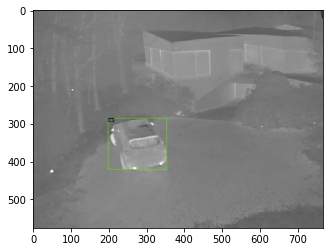

{'file_name': '/run/determined/workdir/shared_fs/data/flir-camera-objects/train/TFront-North-12-01-45-03-20170_jpg.rf.d1d916c51372a90b64a5d5892cb44179.jpg', 'height': 480, 'width': 640, 'image_id': 3985, 'annotations': [{'iscrowd': 0, 'bbox': [186, 165, 30.33, 66.78], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


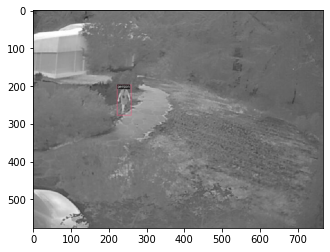

{'file_name': '/run/determined/workdir/shared_fs/data/flir-camera-objects/train/FLIR_07626_jpeg_jpg.rf.89c17a265403eb4deef35248cfd125b1.jpg', 'height': 512, 'width': 640, 'image_id': 3162, 'annotations': [{'iscrowd': 0, 'bbox': [98, 206, 46, 31], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [149, 200, 13, 34], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [160, 195, 13, 37], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [180, 200, 27, 78], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [205, 217, 27, 76], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [228, 203, 17, 69], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [253, 209, 22, 93], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [274, 207, 32, 91], 'category_id': 4, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 

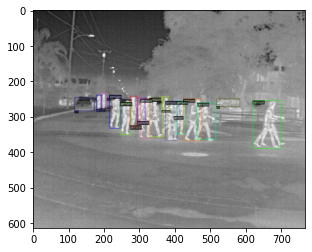

In [20]:

for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :], metadata=nuts_metadata , scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :])
    plt.show()

In [21]:
# cfg.DATASETS.TRAIN = ("train_med_coco",)
# cfg.DATASETS.VAL = ("val_med_coco",)
# cfg.DATASETS.TEST = ("test_med_coco",)
cfg.DATALOADER.NUM_WORKERS = 4

In [22]:
cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.BASE_LR = 0.02/16
# cfg.SOLVER.WARMUP_ITERS = 1000
# cfg.SOLVER.MAX_ITER = 1500
# cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.WARMUP_ITERS = 10
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = (20, 30)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST

0.05

In [23]:
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - test_flir-camera-objects
  TRAIN:
  - train_flir-camera-objects
  VAL:
  - val_flir-camera-objects
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    

In [24]:
# dataloader = build_detection_train_loader(
#             cfg, per_gpu_bs=0, seed=0, rank=0, world_size=0, context='test'
#         )

In [25]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.05

In [26]:
import torch

In [27]:
# torch.cuda.dev

In [28]:


cfg.MODEL.DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
cfg.MODEL.DEVICE

'cuda'

In [29]:
cfg.OUTPUT_DIR

'./output'

In [30]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [31]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 80

cfg.TEST.EVAL_PERIOD = 30

In [ ]:
print(cfg.dump())

In [32]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/17 14:48:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


[05/17 14:49:01 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/17 14:49:43 d2.utils.events]:  eta: 1:11:00  iter: 19  total_loss: 2.098  loss_cls: 1.212  loss_box_reg: 0.1137  loss_rpn_cls: 0.5813  loss_rpn_loc: 0.1244    time: 2.1065  last_time: 1.9331  data_time: 0.0166  last_data_time: 0.0091   lr: 0.001  max_mem: 6979M
WARNING [05/17 14:50:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/17 14:50:06 d2.data.datasets.coco]: Loaded 1452 images in COCO format from /run/determined/workdir/shared_fs/data/flir-camera-objects/test/_annotations.coco.json
[05/17 14:50:06 d2.data.build]: Distribution of instances among all 5 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| flir-camera.. | 0            |  bicycle   | 613          |    car     | 6512         |
|      dog      | 38           |   person   | 3696         |            |        

KeyboardInterrupt: 

In [35]:
test_dataset_name

'test_flir-camera-objects'

In [33]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)

[05/17 15:14:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [36]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# predictor = DefaultPredictor(cfg)

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator(test_dataset_name, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, test_dataset_name)
#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [05/17 15:15:36 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [05/17 15:15:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/17 15:15:36 d2.data.datasets.coco]: Loaded 1452 images in COCO format from /run/determined/workdir/shared_fs/data/flir-camera-objects/test/_annotations.coco.json
[05/17 15:15:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 15:15:36 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/17 15:15:36 d2.data.common]: Serializing 1452 elements to byte tensors and concatenating them all ...
[05/17 15:15:36 d2.data.common]: Serialized dataset takes 0.71 MiB
[05/17 15:15:36 d2.evaluation.evaluator]: Start inferenc

OrderedDict([('bbox',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APs': nan,
               'APm': nan,
               'APl': nan})])

In [38]:

nuts_metadata = MetadataCatalog.get(test_dataset_name)
dataset_dicts = DatasetCatalog.get(test_dataset_name)

WARNING [05/17 15:22:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/17 15:22:39 d2.data.datasets.coco]: Loaded 1452 images in COCO format from /run/determined/workdir/shared_fs/data/flir-camera-objects/test/_annotations.coco.json


In [ ]:
def predict_batch(predictor, im_list):
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            # Do not apply original augmentation, which is resize.
            # image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = original_image
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

In [ ]:

for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    outputs_list = predict_batch(predictor, [img])
    # print(outputs_list)
    visualizer = Visualizer(img[:, :], metadata=nuts_metadata , scale=1.2)
    out = visualizer.draw_instance_predictions(outputs_list[0]["instances"].to("cpu"))
    # vis = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :])
    plt.show()

In [ ]:
# evaluator = COCOEvaluator("train_med_coco", cfg, False, output_dir=cfg.OUTPUT_DIR)
# # val_loader = build_detection_test_loader(cfg, "train_med_coco")
# # inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST